In [1]:
# check the versions of key python libraries 

#import scipy
#print('scipy: %s' % scipy.__version__)

import numpy as np
print('numpy: %s' % np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)

import pandas as pd
print('pandas: %s' % pd.__version__)
from pandas.plotting import autocorrelation_plot

import statsmodels
print('statsmodels: %s' % statsmodels.__version__) # scikit-learn

import sklearn
print('sklearn: %s' % sklearn.__version__)

from sklearn.metrics import mean_squared_error

from tqdm import tqdm
#import requests
import zipfile

#import gc

!python --version


#pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)

numpy: 1.17.2
matplotlib: 3.1.1
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3
Python 3.7.4


In [2]:
# original data files
data_dir = './data/'
data_zip = './data_zip/'

In [3]:
# download file
# source:
# https://www.kaggle.com/unanimad/corona-virus-brazil

print('downloading file .zip ...')
print()
!kaggle datasets download unanimad/corona-virus-brazil --force
print()
print('download finished!')
print()

with zipfile.ZipFile('corona-virus-brazil.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)
print('unziped!')

downloading file .zip ...

  0%|                                               | 0.00/19.7k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 19.7k/19.7k [00:00<00:00, 551kB/s]

download finished!

unziped!


In [4]:
import os

#from datetime import date
#date_today = str(date.today())

if not os.path.exists(data_zip):
    os.mkdir(data_zip)
    print("Directory " , data_zip ,  " Created ")
else:    
    print("Directory " , data_zip ,  " already exists")
    
os.rename("./corona-virus-brazil.zip", data_zip+"corona-virus-brazil.zip")

Directory  ./data_zip/  already exists


In [5]:
print("Files:")
!ls {data_dir}

Files:
brazil_covid19.csv     dataset.csv
brazil_covid19_old.csv validation.csv


In [6]:
covid_br = pd.read_csv(data_dir + 'brazil_covid19.csv')
print('Covid BR has {} rows and {} columns'.format(covid_br.shape[0], covid_br.shape[1]))
print()
print('Last information in ' + covid_br.iloc[-1,0])


Covid BR has 2781 rows and 5 columns

Last information in 2020-05-11


In [7]:
covid_br.head()

,date,region,state,cases,deaths
0,2020-01-30,Centro-Oeste,Distrito Federal,0,0
1,2020-01-30,Centro-Oeste,Goiás,0,0
2,2020-01-30,Centro-Oeste,Mato Grosso,0,0
3,2020-01-30,Centro-Oeste,Mato Grosso do Sul,0,0
4,2020-01-30,Nordeste,Alagoas,0,0


In [8]:
covid_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 5 columns):
date      2781 non-null object
region    2781 non-null object
state     2781 non-null object
cases     2781 non-null int64
deaths    2781 non-null int64
dtypes: int64(2), object(3)
memory usage: 108.8+ KB


In [9]:
df = covid_br[covid_br["state"] == "Amazonas"]

df.tail(5)

,date,region,state,cases,deaths
2661,2020-05-07,Norte,Amazonas,10099,806
2688,2020-05-08,Norte,Amazonas,10727,874
2715,2020-05-09,Norte,Amazonas,11925,962
2742,2020-05-10,Norte,Amazonas,12599,1004
2769,2020-05-11,Norte,Amazonas,12919,1035


In [10]:
df.shape

(103, 5)

In [11]:
df.describe()

,cases,deaths
count,103.000000,103.000000
mean,1556.524272,121.699029
std,3014.505988,244.330652
min,0.000000,0.000000
25%,0.000000,0.000000
50%,11.000000,0.000000
75%,1636.500000,115.000000
max,12919.000000,1035.000000


### Feature Engineering

In [12]:
# datetime

df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df.set_index('date', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2020-01-30 to 2020-05-11
Data columns (total 5 columns):
region         103 non-null object
state          103 non-null object
cases          103 non-null int64
deaths         103 non-null int64
day_of_week    103 non-null object
dtypes: int64(2), object(3)
memory usage: 4.8+ KB


/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
# creating month and day

df['month'] = [df.index[i].month for i in range(len(df))]
df['day'] = [df.index[i].day for i in range(len(df))] 


df.head()

/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,region,state,cases,deaths,day_of_week,month,day
date,,,,,,,
2020-01-30,Norte,Amazonas,0,0,Thursday,1,30
2020-01-31,Norte,Amazonas,0,0,Friday,1,31
2020-02-01,Norte,Amazonas,0,0,Saturday,2,1
2020-02-02,Norte,Amazonas,0,0,Sunday,2,2
2020-02-03,Norte,Amazonas,0,0,Monday,2,3


In [14]:
# creating death by day
df['deaths_d'] = df['deaths'] - df['deaths'].shift(1)

/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# deleting "deaths = 0"
df = df[df["deaths"] > 0]
df.shape

(48, 8)

## Test Harness

### Validation Dataset

In [16]:
X = pd.Series(df['deaths_d'])
split_size = round(len(X) * 0.90)
dataset, validation = X[0:split_size], X[split_size:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 

# save
dataset.to_csv(data_dir+'dataset.csv')
validation.to_csv(data_dir+'validation.csv')

Dataset 43, Validation 5


/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [17]:
# https://medium.com/@bingobee01/pandas-tricks-and-tips-a7b87c3748ea

## Persistence - Base Line Model

In [18]:
# load data

#X = dataset #.values
X = X.astype('float32')
split_size = 0.70

train_size = round(len(X) * split_size)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=16.000, Expected= 31
>Predicted=31.000, Expected= 29
>Predicted=29.000, Expected= 45
>Predicted=45.000, Expected= 51
>Predicted=51.000, Expected= 25
>Predicted=25.000, Expected= 47
>Predicted=47.000, Expected= 36
>Predicted=36.000, Expected= 65
>Predicted=65.000, Expected=102
>Predicted=102.000, Expected= 55
>Predicted=55.000, Expected= 68
>Predicted=68.000, Expected= 88
>Predicted=88.000, Expected= 42
>Predicted=42.000, Expected= 31
RMSE: 25.393


## Data Analysis

### Components of Time Series

Time series analysis provides a body of techniques to better understand a dataset. Perhaps the most useful of these is the decomposition of a time series into 4 constituent parts:

- Level. The baseline value for the series if it were a straight line.

- Trend. The optional and often linear increasing or decreasing behavior of the series over time.
􏰀
- Seasonality. The optional repeating patterns or cycles of behavior over time.

- Noise. The optional variability in the observations that cannot be explained by the model.


p.11

### Concerns of Forecasting

When forecasting, it is important to understand your goal. Use the Socratic method and ask lots of questions to help zoom in on the specifics of your predictive modeling problem. For example:

1. How much data do you have available and are you able to gather it all together? More data is often more helpful, offering greater opportunity for exploratory data analysis, model testing and tuning, and model fidelity.

2. What is the time horizon of predictions that is required? Short, medium or long term? Shorter time horizons are often easier to predict with higher confidence.

3. Can forecasts be updated frequently over time or must they be made once and remain static? Updating forecasts as new information becomes available often results in more accurate predictions.

4. At what temporal frequency are forecasts required? Often forecasts can be made at a lower or higher frequencies, allowing you to harness down-sampling, and up-sampling of data, which in turn can offer benefits while modeling.


Time series data often requires cleaning, scaling, and even transformation. For example:

- Frequency. Perhaps data is provided at a frequency that is too high to model or is unevenly spaced through time requiring resampling for use in some models.

- Outliers. Perhaps there are corrupt or extreme outlier values that need to be identified and handled.

- Missing. Perhaps there are gaps or missing data that need to be interpolated or imputed.

p.12

______

- Sliding Window, p.15

- Sliding Window With Multivariates, p.16

- Sliding Window With Multiple Steps, p.18

- Lag Features, p.29: X.shift(1)

- Rolling Window Statistics, p.31: rolling(X).mean()

        width = 3
        shifted = temps.shift(width - 1)
        window = shifted.rolling(window=width)
        dataframe = concat([window.min(), window.mean(), window.max(), temps], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


- Expanding Window Statistics, p.33: expanding()

        temps = DataFrame(series.values)
        window = temps.expanding()
        dataframe = concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


### Summary Statistics

In [19]:
# Number of Observations
X.shape

(48,)

In [20]:
# Descriptive Statistics
X.describe()

count     48.000000
mean      21.562500
std       23.783514
min        0.000000
25%        3.750000
50%       16.000000
75%       31.000000
max      102.000000
Name: deaths_d, dtype: float64

### Line Plot

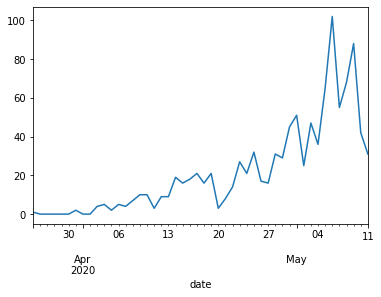

In [21]:
X.plot()
plt.show()

- Increasing trend of cases over time.
- There do not appears to be systematic seasonality to the cases for each day.
- There do not appear to be any obvious outliers.

### Histogram and Density Plot

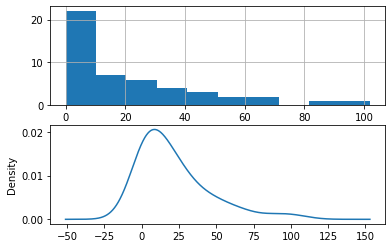

In [22]:
plt.figure(1)
plt.subplot(211)
X.hist()

plt.subplot(212)
X.plot(kind='kde')
plt.show()

- The distribution is not Guassian.
- The shape has a long right rail and may suggest an exponential distribution.

### Box and Whisker Plots

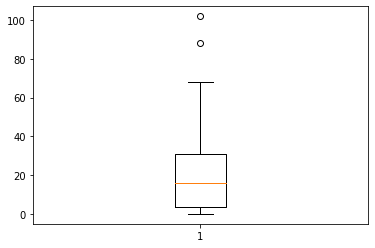

In [23]:
plt.boxplot(X)
plt.show()

- There are outliers on the top.

### Heat Maps

In [24]:
# Analysing correlations
''' 
import seaborn as sns

corr = series.corr()
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.set()
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)

plt.show()
'''

'''
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='A')) years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years = years.T
pyplot.matshow(years, interpolation=None, aspect='auto') 
pyplot.show()
# p.46
'''



"\nseries = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0,\nparse_dates=True, squeeze=True)\ngroups = series.groupby(Grouper(freq='A')) years = DataFrame()\nfor name, group in groups:\n    years[name.year] = group.values\nyears = years.T\npyplot.matshow(years, interpolation=None, aspect='auto') \npyplot.show()\n# p.46\n"

### Lag Scatter Plots

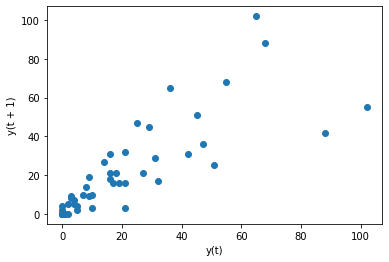

In [25]:
from pandas.plotting import lag_plot
lag_plot(X)
plt.show()

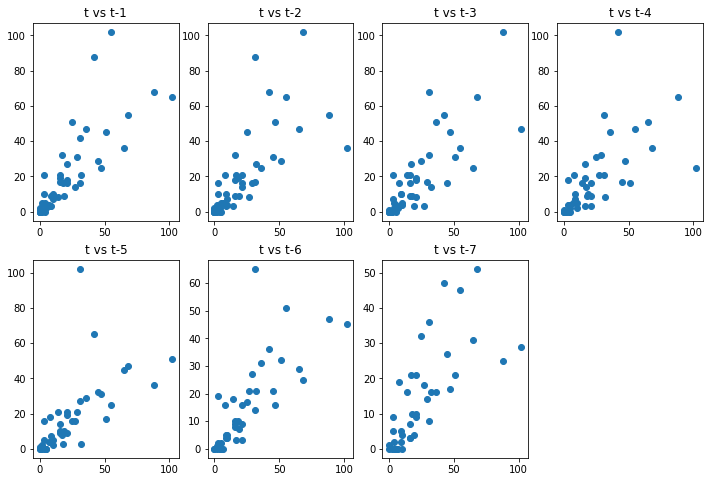

In [26]:
from pandas import concat

lags = 7
columns = [X]

for i in range(1,(lags + 1)):
    columns.append(X.shift(i))

dataframe = concat(columns, axis=1) 
columns = ['t']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i)) 

dataframe.columns = columns 
plt.figure(1, figsize=(12, 8))

for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

### Autocorrelation

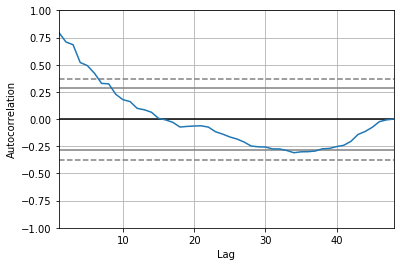

In [27]:
# autocorrelation
autocorrelation_plot(X)
plt.show()

### Resampling

Two types of resampling are:

- Upsampling: Where you increase the frequency of the samples, such as from minutes to seconds.

- Downsampling: Where you decrease the frequency of the samples, such as from days to months.

There are perhaps two main reasons why you may be interested in resampling your time series data:

- 􏰀Problem Framing: Resampling may be required if your data is available at the same frequency that you want to make predictions.

- Feature Engineering: Resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models.

p.53

In [28]:
df.head(2)

,region,state,cases,deaths,day_of_week,month,day,deaths_d
date,,,,,,,,
2020-03-25,Norte,Amazonas,54,1,Wednesday,3,25,1.0
2020-03-26,Norte,Amazonas,67,1,Thursday,3,26,0.0


In [29]:
# visualize downsampling to "week" mean

week_mean = df["deaths_d"].resample('W', level=0).mean()
week_mean

date
2020-03-29     0.200000
2020-04-05     1.857143
2020-04-12     6.857143
2020-04-19    17.142857
2020-04-26    17.428571
2020-05-03    34.857143
2020-05-10    65.142857
2020-05-17    31.000000
Freq: W-SUN, Name: deaths_d, dtype: float64

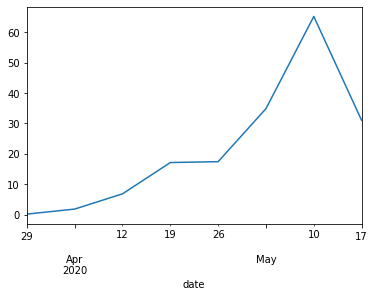

In [30]:
week_mean.plot() 
plt.show()

In [31]:
# week sum

week_sum = df["deaths_d"].resample('W', level=0).sum()
week_sum

date
2020-03-29      1.0
2020-04-05     13.0
2020-04-12     48.0
2020-04-19    120.0
2020-04-26    122.0
2020-05-03    244.0
2020-05-10    456.0
2020-05-17     31.0
Freq: W-SUN, Name: deaths_d, dtype: float64

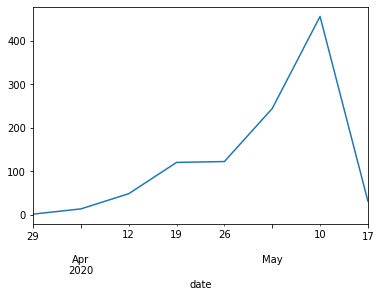

In [32]:
week_sum.plot() 
plt.show()

## Power Transforms

### Quadratic Transform

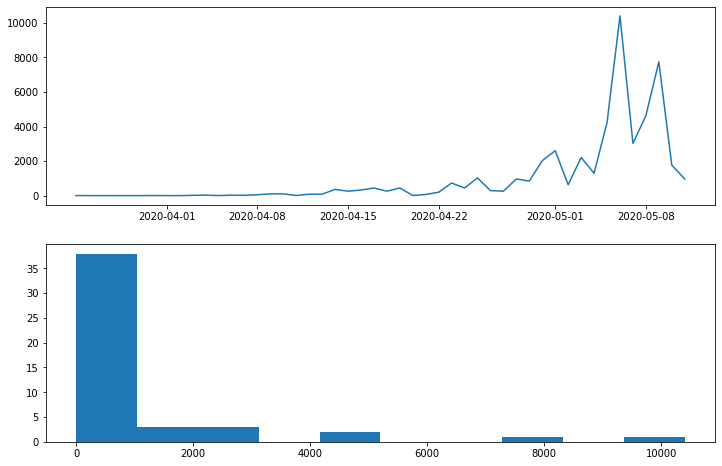

In [33]:
# contrive a quadratic time series

df['deaths_d_quad'] = df['deaths_d']**2
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_quad'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_quad'])
plt.show()

### Square Root Transform

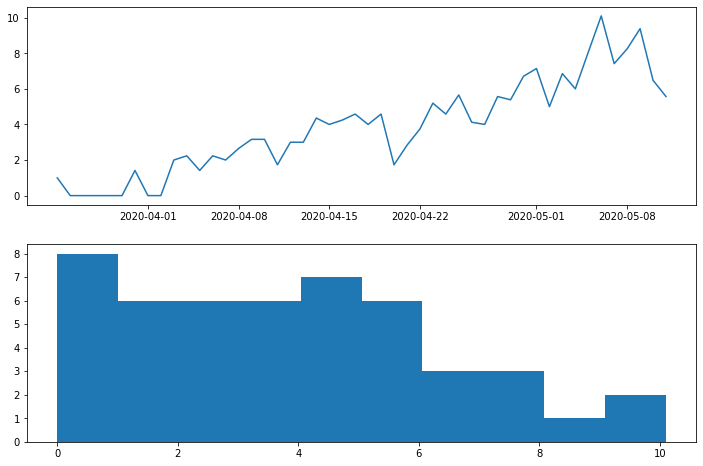

In [34]:
# square root transform a time series

df['deaths_d_sqrt'] = np.sqrt(df['deaths_d']) 
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_sqrt'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_sqrt'])
plt.show()

### Exponential Transform

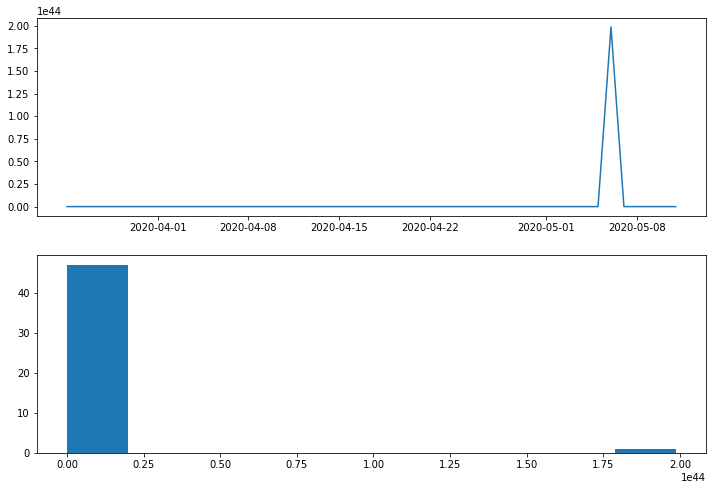

In [35]:
df['deaths_d_exp'] = np.exp(df['deaths_d']) 
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_exp'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_exp'])
plt.show()

### Log Transform

/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


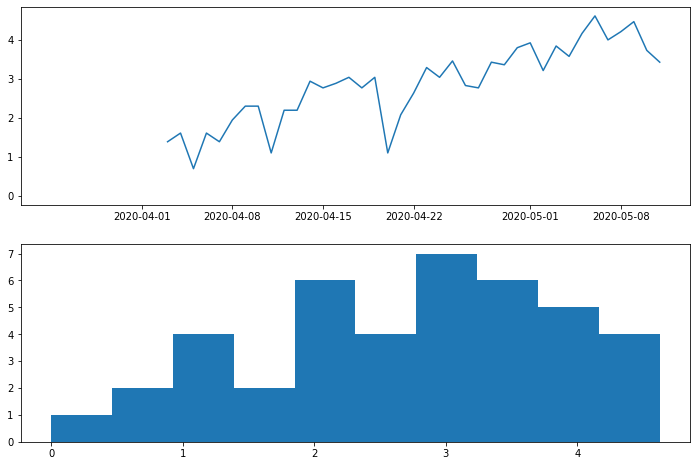

In [36]:
df['deaths_d_log'] = np.log(df['deaths_d']) 
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_log'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_log'][np.isfinite(df['deaths_d_log'])].values)
plt.show()

### Box-Cox Transform

Below are some common values for lambda:
􏰀
- lambda = -1. is a reciprocal transform.
􏰀
- lambda = -0.5 is a reciprocal square root transform. 􏰀 lambda = 0.0 is a log transform.
􏰀
- lambda = 0.5 is a square root transform.
􏰀
- lambda = 1.0 is no transform.

/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


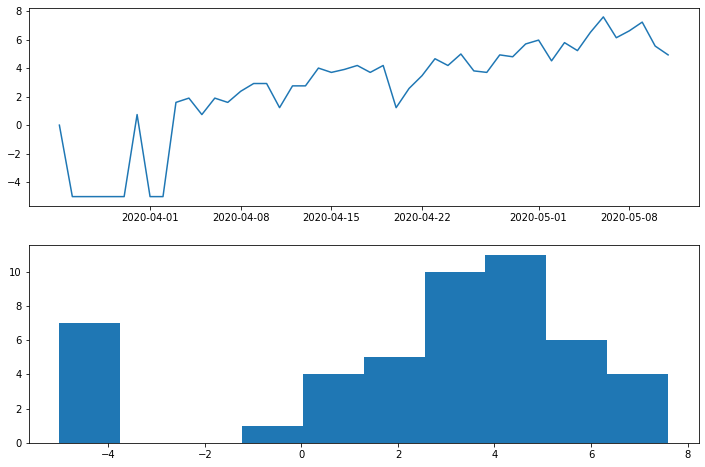

In [37]:
from scipy.stats import boxcox

# boxcox doesn't support zeros
# https://stackoverflow.com/questions/50180988/valueerror-data-must-be-positive-boxcox-scipy

data_positive = df['deaths_d'][df['deaths_d'] > 0]
bcdata, lam = boxcox(data_positive)

df['deaths_d_boxcox'] = df['deaths_d']
df['deaths_d_boxcox'][df['deaths_d'] > 0] = bcdata
df['deaths_d_boxcox'][df['deaths_d'] == 0] = -1/lam

plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_boxcox'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_boxcox'])
plt.show()

## Moving Average Smoothing

- Centered Moving Average

center_ma(t) = mean(obs(t − 1), obs(t), obs(t + 1))

- Trailing Moving Average

trail_ma(t) = mean(obs(t − 2), obs(t − 1), obs(t))

=> It is assumed that both trend and seasonal components have been removed from your time series.

date
2020-03-25         NaN
2020-03-26         NaN
2020-03-27    0.333333
2020-03-28    0.000000
2020-03-29    0.000000
2020-03-30    0.000000
2020-03-31    0.666667
2020-04-01    0.666667
2020-04-02    0.666667
2020-04-03    1.333333
Name: deaths_d, dtype: float64


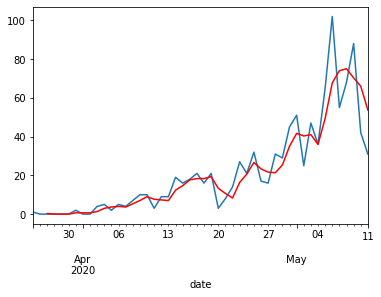

In [49]:
# tail-rolling average transform
rolling = X.rolling(window=3) 
rolling_mean = rolling.mean() 
print(rolling_mean.head(10))

# plot original and transformed dataset 
X.plot() 
rolling_mean.plot(color='red') 
plt.show()

## Moving Average as Feature Engineering

In [52]:
df = pd.DataFrame(X.values)
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = concat([means, lag1, df], axis=1) 
dataframe.columns = ['mean', 't', 't+1'] 
print(dataframe.head(10))

       mean    t  t+1
0       NaN  NaN  1.0
1       NaN  1.0  0.0
2       NaN  0.0  0.0
3       NaN  0.0  0.0
4  0.333333  0.0  0.0
5  0.000000  0.0  0.0
6  0.000000  0.0  2.0
7  0.000000  2.0  0.0
8  0.666667  0.0  0.0
9  0.666667  0.0  4.0


## Moving Average as Prediction

In [56]:
# prepare situation
# X = series.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)]) 
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

predicted=0.333333, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=2.000000
predicted=0.666667, expected=0.000000
predicted=0.666667, expected=0.000000
predicted=0.666667, expected=4.000000
predicted=1.333333, expected=5.000000
predicted=3.000000, expected=2.000000
predicted=3.666667, expected=5.000000
predicted=4.000000, expected=4.000000
predicted=3.666667, expected=7.000000
predicted=5.333333, expected=10.000000
predicted=7.000000, expected=10.000000
predicted=9.000000, expected=3.000000
predicted=7.666667, expected=9.000000
predicted=7.333333, expected=9.000000
predicted=7.000000, expected=19.000000
predicted=12.333333, expected=16.000000
predicted=14.666667, expected=18.000000
predicted=17.666666, expected=21.000000
predicted=18.333334, expected=16.000000
predicted=18.333334, expected=21.000000
predicted=19.333334, expected=3.000000
predicted=13.333333, expected=8.000000
predicted=10.666667, expected=14.00

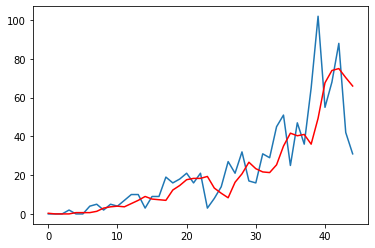

In [57]:
# plot
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

# zoom plot
#pyplot.plot(test[:100]) pyplot.plot(predictions[:100], color='red') pyplot.show()

____
## Temporal Structure

### White Noise

- White noise is an important concept in time series forecasting. If a time series is white noise, it is a sequence of random numbers and cannot be predicted.

- A time series may be white noise. A time series is white noise if the variables are independent and identically distributed with a mean of zero. This means that all variables have the same variance (sigma2) and each value has a zero correlation with all other values in the series. If the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian white noise.

- Predictability: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.

- Model Diagnostics: The series of errors from a time series forecast model should ideally be white noise.

Is your Time Series White Noise?
Your time series is not white noise if any of the following conditions are true:
- Does your series have a non-zero mean?
- Does the variance change over time?
- Do values correlate with lag values?

Some tools that you can use to check if your time series is white noise are:
- Create a line plot. Check for gross features like a changing mean, variance, or obvious relationship between lagged variables.
- Calculate summary statistics. Check the mean and variance of the whole series against the mean and variance of meaningful contiguous blocks of values in the series (e.g. days, months, or years).
- Create an autocorrelation plot. Check for gross correlation between lagged variables.


count     48.000000
mean      21.562500
std       23.783514
min        0.000000
25%        3.750000
50%       16.000000
75%       31.000000
max      102.000000
Name: deaths_d, dtype: float64


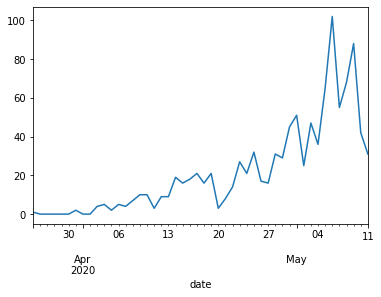

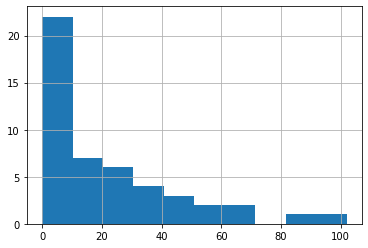

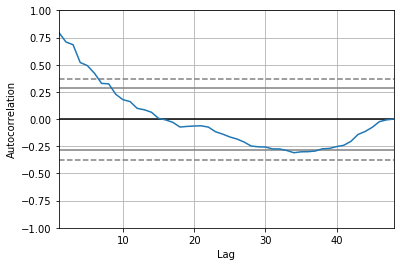

In [65]:
# summary stats
print(X.describe())

# line plot
X.plot()
plt.show()

# histogram plot
X.hist()
plt.show()

# autocorrelation
autocorrelation_plot(X)
plt.show()

### Augmented Dickey-Fuller test

We can expect a random walk to be non-stationary. In fact, all random walk processes are non-stationary. Note that not all non-stationary time series are random walks. Additionally, a non-stationary time series does not have a consistent mean and/or variance over time. A review of the random walk line plot might suggest this to be the case. We can confirm this using a statistical significance test.


In [67]:
from statsmodels.tsa.stattools import adfuller

# statistical test
result = adfuller(X) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.397338
p-value: 0.583552
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603


The null hypothesis of the test is that the time series is non-stationary. Running the example, we can see that the test statistic value was 0.341605. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary with a low likelihood of the result being a statistical fluke.

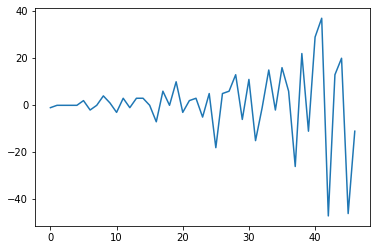

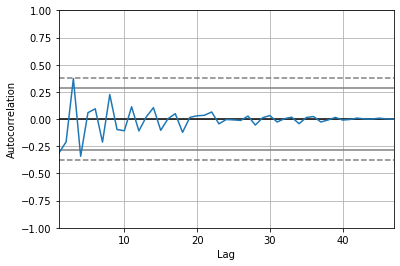

In [69]:
# take difference
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)

# line plot
plt.plot(diff)
plt.show()

autocorrelation_plot(diff)
plt.show()

## ARIMA Models

In [38]:
from statsmodels.tsa.arima_model import ARIMA

- there are high correlations before day 3.

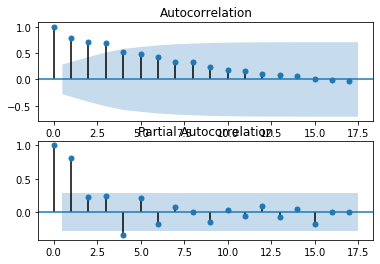

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(X, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, ax=plt.gca())
plt.show()

In [44]:
# ARIMA
p = 4   # Autocorrelation Function (ACF)

d = 1   # level of differencing

q = 0   # Partial Autocorrelation Function (PACF)

                             ARIMA Model Results                              
Dep. Variable:             D.deaths_d   No. Observations:                   47
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -183.558
Method:                       css-mle   S.D. of innovations             11.883
Date:                Tue, 12 May 2020   AIC                            379.116
Time:                        13:08:12   BIC                            390.217
Sample:                    03-26-2020   HQIC                           383.294
                         - 05-11-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0431      0.910      1.146      0.258      -0.741       2.827
ar.L1.D.deaths_d    -0.3286      0.149     -2.200      0.033      -0.621      -0.036
ar.L2.D.deaths_d    -0.4343 

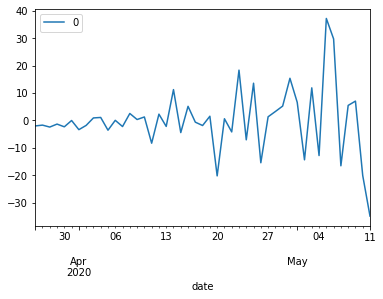

               0
count  47.000000
mean   -0.065874
std    12.014439
min   -34.954255
25%    -3.495264
50%    -0.054315
75%     4.174225
max    37.198898


In [45]:
# fit model
model = ARIMA(X, order=(p,d,q))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

### Grid Search ARIMA Hyperparameters

In [43]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order): # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
             for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # evaluate parameters
p_values = range(0, 6)
d_values = range(0, 6)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

evaluate_models(dataset, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=35.420
ARIMA(0, 0, 1) RMSE=27.636
ARIMA(0, 0, 2) RMSE=22.786
ARIMA(0, 0, 3) RMSE=21.658
ARIMA(0, 1, 0) RMSE=18.158
ARIMA(0, 1, 1) RMSE=20.568
ARIMA(0, 1, 2) RMSE=20.499
ARIMA(0, 2, 0) RMSE=25.997
ARIMA(0, 2, 1) RMSE=18.028
ARIMA(1, 0, 0) RMSE=19.959
ARIMA(1, 1, 0) RMSE=19.198
ARIMA(1, 1, 1) RMSE=21.174
ARIMA(1, 2, 0) RMSE=20.532
ARIMA(2, 0, 0) RMSE=20.666
ARIMA(2, 1, 0) RMSE=19.797
ARIMA(2, 1, 1) RMSE=22.185
ARIMA(2, 2, 0) RMSE=19.816
ARIMA(3, 0, 0) RMSE=21.223
ARIMA(3, 1, 0) RMSE=21.076
ARIMA(3, 1, 1) RMSE=21.525
ARIMA(3, 2, 0) RMSE=20.421
ARIMA(4, 0, 0) RMSE=22.284
ARIMA(4, 1, 0) RMSE=18.017
ARIMA(4, 2, 0) RMSE=19.820
ARIMA(5, 0, 0) RMSE=20.349
ARIMA(5, 1, 0) RMSE=18.598
ARIMA(5, 2, 0) RMSE=14.987
Best ARIMA(5, 2, 0) RMSE=14.987


### Moving Average as Data Preparation

In [ ]:
X = pd.Series(df['deaths_d'])
rolling = X.rolling(window=3) 
rolling_mean = rolling.mean() 
print(rolling_mean.head(10))

In [ ]:
# plot original and transformed dataset 
X.plot() 
rolling_mean.plot(color='red') 
plt.show()

### Moving Average as Feature Engineering

In [ ]:


# prepare situation
#X = deaths.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)]) 
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

# zoom plot
#pyplot.plot(test[:100]) pyplot.plot(predictions[:100], color='red') pyplot.show()

### Is your Time Series White Noise?

In [ ]:
X.describe()

# mean is not zero
# standard deviation is high

In [ ]:
# histogram plot
X.hist()
plt.show()

# histogram is not a bell curve.

### Check Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# statistical test

# The null hypothesis of the test is that the time series is non-stationary.
# https://machinelearningmastery.com/time-series-data-stationary-python/
# https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test

result = adfuller(X) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Time Series Components

Systematic Components:
- Level
- Trend
- Seasonality

Nos-Systematic Component:
- Noise


### Automatic Time Series Decomposition

### Additive Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(X, model='additive', freq=1) 
result.plot()
plt.show()

### Multiplicative Decomposition

In [ ]:
result = seasonal_decompose(X, model='multiplicative', freq=1) 
result.plot()
plt.show()

### Log transformation

In [ ]:
result = adfuller(np.log(X)) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Detrend by Model Fitting

In [ ]:
??????


from sklearn.linear_model import LinearRegression

# fit linear model
X = [i for i in range(0, len(X))]
X = np.reshape(X, (len(X), 1))
y = dataset.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(deaths))]

# plot detrended
plt.plot(detrended)
plt.show()

In [ ]:
detrended

In [ ]:
result = adfuller(detrended) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))